# Group Assignment 1: Human Activity Detection
In this assignment you will create you own dataset for classification. You will explore which ML algorithms are best to classify this and you will present your best solution. 

- Create your own dataset for custom human motions using Phyphox
- There should be at least 3 distinct types of motions
- The motions should be different to the ones used in the UCI dataset (Not: walking, sitting, standing, laying, stairs)
- Follow the steps and answer the questions given in this notebook

### Generating your dataset:

For this assignment you will create your own dataset of motions that you collect with an Accelerometer and Gyroscope. For this you can use your phone as a sensor.
To be able to collect your data you can best use an app called [phyphox](https://phyphox.org/), this is a free app available in app stores. This app can be configured to acces your sensordata, sample it as given frequency's. you can set it up te have experiment timeslots, and the data with a timestamp can be exported to a needed output format.

![](https://phyphox.org/wp-content/uploads/2019/06/phyphox_dark-1024x274.png)

When you installed the app you can setup a custum experiment by clicking on the + button. Define an experiment name, sample frequency and activate the Accelerometer and Gyroscope. Your custom experiment will be added, you can run it pressing the play button and you will see sensor motion. Pressing the tree dots (...) lets you define timed runs, remote access and exporting data.

Phyphox will generate 2 files with sensor data, one for the Accelerometer and one for the Giro. Both files will have timestamps which might not match the recorded sensor data for each sensor. Please, preprocess and merge the files for using it as your dataset for training, testing and deploying your own supervised learning model.

### steps

With your own generated dataset the similar sequence of steps should be taken to train your model.

These are the generic steps to be taken
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.
9. Additional Questions


---
In the Notebook this structure is used for dividing the different steps, so make sure you do the implementation and analisis at these location in the notebook. 

You may add additinal code blocks, but keep the seperation of the given structure.

At the end of each block summarize / comment / conclude your current step in the given textblocks.




```
Roel van der Leest // 4910087
Jari van hoof // 4938135
Wout van der zanden // 4845250
```


# 1. Frame the problem and look at the big picture
*Describe the problem at hand and explain your approach*

### Problem Description
The goal of this assignment is to develop a machine learning model capable of recognizing specific human activities based on sensor data. We will distinguish between three gestures using data collected from a smartphone's accelerometer and gyroscope.

### Selected Activities
We have chosen three motions that involve different arm trajectories:
1.  **Drawing the letter 'O':** A continuous circular motion performed in the air.
2.  **Throwing a ball:** A rapid, linear acceleration followed by a deceleration.
3.  **Opening a door:** A reach-and-pull or push-and-turn motion.

### Approach & Methodology
*   **Data Collection:** We will use the Phyphox app to record 3-axis Accelerometer and Gyroscope data.
*   **Hardware Consistency:** To eliminate overfitting to one specific device its sensors, we will use 2 different smartphones for all data collection.
*   **Bias Mitigation:** To ensure our model learns the motion rather than a specific person's movement style, we will have each group member perform 10 movements with one phone, following 10 times the same movement with the other phone. This results in total 60 samples per activity which is build up from 2 different phones and 3 different people.


# 2. Get the data.

### Data Collection Protocol
As explained above, to ensure good data and minimize bias we have established the following protocol:
*   **Device:** Two phones will be used for all recordings to eliminate hardware sensor variance.
*   **Participants:** each group member will perform the motions to prevent the model from overfitting to a single person's movement style.
*   **Volume:** We aim for 20 samples per person per movement with 10 samples on each phone.
*   **Sampling:** We will use fixed time windows in Phyphox to ensure consistent data length for each sample.
*   **Phone Placement:** The phone will be held in the right hand in a predefined orientation for all recordings.
*   **Data saving:** For our own clarity data will be saved under /[activity_name]/[phone_name]/[person_name]. So for example: a sample measured on jari's phone with the activity 'drawing an O' performed by roel will be saved under /letter O movement data/phone jari/test roel/

### The Classes
We will classify the following 3 activities:

#### 1. Opening a Door
*   **Action:** Miming the action of reaching for a handle, turning/pushing, and returning.
*   **Start Position:** Hands beside the body.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Hands beside the body.
*   **Phone Orientation:** [TODO: Add image of phone grip]

#### 2. Drawing the Letter 'O'
*   **Action:** Drawing a large circle in the air.
*   **Start Position:** Hands in front of the body at the top of the 'O'.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Same as start position (completing the loop).
*   **Phone Orientation:** [TODO: Add image of phone grip]

#### 3. Throwing a Ball
*   **Action:** Miming an overhand throw.
*   **Start Position:** Hands beside the body.
*   **Movement:** As shown in the video [TODO: Add video reference].
*   **End Position:** Hand at the top of the arc, after the "release".
*   **Phone Orientation:** [TODO: Add image of phone grip]

<!-- ### Data Loading & Merging Strategy

**Addressing your question:** *"Shouldn't we separate by folder?"*

We **are** separating the data logically, but storing it in a single efficient structure for Machine Learning.

**1. The `Activity` Label:**
Instead of creating separate variables for each folder, we add an `Activity` column.
*   The script automatically detects if a sample is "Door Movement", "Letter O", or "Throwing Ball" based on the folder path.
*   This creates the **Labels ($y$)** required for supervised learning.

**2. The `Sample_ID`:**
*   We assign a unique `Sample_ID` to every 5-second recording found.
*   This allows us to distinguish between individual movements (e.g., "Door Movement #1", "Door Movement #2") within the large dataset.

**Why this format?**
This "Long Format" (Time-Series) is the standard starting point. In **Step 4**, we will group by `Sample_ID` to calculate features (e.g., mean acceleration, max gyro) for each unique movement, creating the final training set. -->

# 3. Explore the data to gain insights.

*Explore the data in any possible way, visualize the results (if you have multiple plots of the same kind of data put them in one larger plot)*

After conducting all the data collection with pyphox all the data was inside a Zip file, plus it included unnecessary meta data. Manually unzipping and cleaning this data would be very time consuming. Therefore, we used a python script that automatically unzips all files and removes unnecessary meta data.

In [104]:
import os
import zipfile
import shutil

def unzip_and_clean(target_directory):
    
    if not os.path.exists(target_directory):
        print(f"Directory not found: {target_directory}")
        return

    # Walk through all directories recursively
    for root, dirs, files in os.walk(target_directory):
        # Check all files in the current directory
        for filename in files:
            file_path = os.path.join(root, filename)

            # Check if it's a zip file
            if filename.lower().endswith('.zip'):
                # Create a directory name based on the zip file (removing .zip extension)
                extract_folder_name = os.path.splitext(filename)[0]
                extract_path = os.path.join(root, extract_folder_name)
                
                # Unzip
                try:
                    with zipfile.ZipFile(file_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                    
                    # Remove 'meta' directory if it exists
                    meta_dir = os.path.join(extract_path, 'meta')
                    if os.path.exists(meta_dir) and os.path.isdir(meta_dir):
                        shutil.rmtree(meta_dir)
                        
                    os.remove(file_path)
                except zipfile.BadZipFile:
                    print(f"Error: {filename} is a bad zip file.")
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

if __name__ == "__main__":
    # Base directory containing all movement data folders
    base_dir = r"C:\Users\roelv\Documents\Machine Learning\AIS\assignment 1"
    
    # Process all movement data directories
    movement_types = ["Door movement data", "letter O movement data", "throwing ball movement data"]
    
    for movement_type in movement_types:
        target_dir = os.path.join(base_dir, movement_type)
        if os.path.exists(target_dir):
            print(f"Processing: {movement_type}")
            unzip_and_clean(target_dir)
    
    print("Done!")


Processing: Door movement data
Processing: letter O movement data
Processing: throwing ball movement data
Done!


After succesfully unzipping and cleaning the data, we load all the data files into a single pandas DataFrame. Each file is labeled with its corresponding activity based on the folder structure.

In [105]:
import pandas as pd
import os

def get_label_from_path(path):
    path_lower = path.lower()
    if 'door' in path_lower:
        return 'Door Movement'
    elif 'letter o' in path_lower:
        return 'Letter O'
    elif 'ball' in path_lower or 'throw' in path_lower:
        return 'Throwing Ball'
    return 'Unknown'

def load_and_merge_data(base_dir):
    all_data = []
    sample_id_counter = 1
    
    # Walk through all folders
    for root, dirs, files in os.walk(base_dir):
        # We only care about folders that contain both sensor files
        if 'Accelerometer.csv' in files and 'Gyroscope.csv' in files:
            try:
                # 1. Construct file paths
                acc_path = os.path.join(root, 'Accelerometer.csv')
                gyro_path = os.path.join(root, 'Gyroscope.csv')
                
                # 2. Load the data
                df_acc = pd.read_csv(acc_path)
                df_gyro = pd.read_csv(gyro_path)
                
                # 3. Rename columns to avoid confusion after merge
                # renaming for clarity
                df_acc = df_acc.rename(columns={
                    df_acc.columns[0]: 'Time', 
                    df_acc.columns[1]: 'Acc_X', 
                    df_acc.columns[2]: 'Acc_Y', 
                    df_acc.columns[3]: 'Acc_Z'
                })
                
                df_gyro = df_gyro.rename(columns={
                    df_gyro.columns[0]: 'Time', 
                    df_gyro.columns[1]: 'Gyro_X', 
                    df_gyro.columns[2]: 'Gyro_Y', 
                    df_gyro.columns[3]: 'Gyro_Z'
                })
                
                # 4. Sort by time (required for merge_asof)
                df_acc = df_acc.sort_values('Time')
                df_gyro = df_gyro.sort_values('Time')
                
                # 5. Merge: Align Gyro data to the nearest Accelerometer timestamp
                # This handles the mismatched time frames/frequencies
                df_merged = pd.merge_asof(df_acc, df_gyro, on='Time', direction='nearest')
                
                # 6. Add Metadata
                df_merged['Activity'] = get_label_from_path(root) ## Note in machine learning models don't use string labels, this is only for our clarity for now.
                                                                  ## in chapter 4 we will convert these integers.
                df_merged['Sample_ID'] = sample_id_counter
                
                all_data.append(df_merged)
                sample_id_counter += 1
                
            except Exception as e:
                print(f"Error processing {root}: {e}")
                
    # Combine all samples into one big DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()

# Run the loading function
# We use '.' to search in the current directory and subdirectories
df_final = load_and_merge_data('.')

# Display results
print(f"Successfully loaded {len(df_final)} data points.")
print(f"Total unique samples (recordings): {df_final['Sample_ID'].nunique()}")
print("\nClass distribution:")
print(df_final['Activity'].value_counts())

# Show the first few rows
df_final.head()

Successfully loaded 45096 data points.
Total unique samples (recordings): 180

Class distribution:
Activity
Throwing Ball    15052
Letter O         15048
Door Movement    14996
Name: count, dtype: int64


,Time,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,Activity,Sample_ID
0,-0.001773,9.166488,-3.286116,2.056723,0.310439,-0.062838,0.070347,Door Movement,1
1,0.018317,9.422306,-3.262615,2.197879,0.362224,-0.108883,0.053720,Door Movement,1
2,0.038407,9.295220,-3.129093,1.997147,0.347363,-0.165629,0.053675,Door Movement,1
3,0.058497,9.314381,-3.121459,2.042054,0.297007,-0.155002,0.038126,Door Movement,1
4,0.078587,9.304651,-3.115471,2.310296,0.324873,-0.132150,0.095936,Door Movement,1


*Script Explanation:*

- **Single DataFrame (long format):** We combine all recordings into one DataFrame so analysis, plotting, filtering, and later feature extraction are simple and consistent. A single table lets us easily group by recording Sample_ID and activity.

- **`Sample_ID`:** Each folder contains one recording (one activity). We assign a unique `Sample_ID` to every recording so we can treat each gesture as one sample later. During feature extraction we will group by Sample_ID

- **Merging accelerometer and gyroscope:** Phyphox exports two separate files per recording (Accelerometer.csv and Gyroscope.csv) with their own timestamps and sampling jitter. We use `pd.merge_asof` to align them: it matches each accelerometer timestamp with the nearest gyroscope timestamp. This is preferred because it preserves the main timeline (we merge onto `Time` from one sensor). and it deals robustly with slightly different sampling rates.


# 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

prepare your data, is it normalized? are there outlier? Make a training and a test set.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

### Data preperation

Our raw data is a Time-Series: for every single "Door Opening" movement, we have around 250 sensor readings (e.g., 5 seconds at 50Hz = 250 rows).

Most standard Machine Learning algorithms cannot handle raw time-series data directly. They expect a different format where:
*   1 Row = 1 Sample (one complete gesture)
*   Columns= Features describing that gesture

To solve this, We group all the sensor readings for a single `Sample_ID` and calculate summary statistics (like the average acceleration). This compresses the time-series into a single "fingerprint" for that movement. 

### Feature selection

At first we decided to use mean, std, min, max and range for each of the 6 sensor axes (Acc_X, Acc_Y, Acc_Z, Gyro_X, Gyro_Y, Gyro_Z). To this we would also add the magnitude features for both sensors. This resulted in 36 features per sample. The correlation matrix however showed us that a lot of features were highly correlated. Therefore, we decided to drop some features and only keep mean, std and range for both sensors. and for the magnitude features we only kept mean and std. This resulted in a total of 22 features. The correleation matrix of this setup looked like this:

![image.jpeg](./images/correlation%20matrix%20v1.jpeg)

By looking at the correlation matrix above we concluded the following two things:

* we initially thought using the magnitude would be usefull because if you hold the phone slightly differently (rotated), the X, Y, and Z values change completely, but the total magnitude of the acceleration remains the same. However as can be seen in the correlation matrix above, the magnitude features are highly correlated. Therefore, we decided to drop them.

* the range and std features are also highly correlated. However, we decided to keep both because they capture slightly different aspects of the motion. The std captures how much the movement on average varies around the mean, while the range captures the total spread between the minimum and maximum values. We believe both could be relevant for distinguishing between our chosen activities.


This ended us up with 18 features consisting of:
*   **Mean & Standard Deviation:** Captures the average intensity and how much the movement varies.
*   **Range:** Captures the extremes of the motion (e.g., the peak acceleration during a throw).

the correlation matrix of this setup looked like this:

![image.png](./images/correlation%20matrix%20v2.png)

as shown above the correlation between the range and std is especially high for the gyroscope's x,y,z features. whilst for the acceleration this is only the case for the x and y features. Therefore we decided to drop the range features for these. And only keep the std and range for the acceleration z axis. since the correlation between for this axis is lower.

This ended us up with 13 features consisting of:
*   **Mean & Standard Deviation:** Captures the average intensity and how much the movement varies.
*   **Range:** Captures the extremes of the motion (e.g., the peak acceleration during a throw), only applied to Acc_Z.

the correlation matrix of this final setup is shown a bit below in the correlation analysis section.

**Now finally below the code preparing the data and extracting the features can be seen below:**




In [107]:
def extract_features(df):
    # Group by Sample_ID and Activity (Activity is constant for a sample)
    grouped = df.groupby(['Sample_ID', 'Activity'])
    
    features = []
    labels = []
    
    for (sample_id, activity), group in grouped:
        # Extract raw sensor columns
        sensor_cols = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
        
        sample_features = {}
        
        # Calculate stats for each axis
        for col in sensor_cols:
            sample_features[f'{col}_mean'] = group[col].mean()
            sample_features[f'{col}_std'] = group[col].std()
        ## only allow range feature for Z axis to reduce feature correlation
            if col == 'Acc_Z' :
                sample_features[f'{col}_range'] = group[col].max() - group[col].min()

        ## -- commend out since we dropped magnitude features for now -- ##
        # Acc Magnitude = sqrt(x^2 + y^2 + z^2)
        # acc_mag = np.sqrt(group['Acc_X']**2 + group['Acc_Y']**2 + group['Acc_Z']**2)
        # sample_features['Acc_Mag_mean'] = acc_mag.mean()
        # sample_features['Acc_Mag_std'] = acc_mag.std()
        
        # gyro_mag = np.sqrt(group['Gyro_X']**2 + group['Gyro_Y']**2 + group['Gyro_Z']**2)
        # sample_features['Gyro_Mag_mean'] = gyro_mag.mean()
        # sample_features['Gyro_Mag_std'] = gyro_mag.std()
        ## --------------------------------------------------------- ##

        features.append(sample_features)
        labels.append(activity)
        
    return pd.DataFrame(features), pd.Series(labels)

### Applying Feature Extraction
Now that we have defined our function, we apply it to our dataset. This transforms our long time-series data into a dataset where each row represents a single motion sample with the extracted features.

In [108]:
# Apply feature extraction
X_raw, y_raw = extract_features(df_final)
print(f"Feature extraction complete. New shape: {X_raw.shape}")

# to show the first few rows
X_raw.head()


Feature extraction complete. New shape: (180, 13)


,Acc_X_mean,Acc_X_std,Acc_Y_mean,Acc_Y_std,Acc_Z_mean,Acc_Z_std,Acc_Z_range,Gyro_X_mean,Gyro_X_std,Gyro_Y_mean,Gyro_Y_std,Gyro_Z_mean,Gyro_Z_std
0,8.339460,2.741293,-1.713968,1.722366,-2.624064,4.320133,21.928949,-0.127083,0.991928,-0.017600,1.208471,0.079541,0.969020
1,8.229681,2.478081,-1.225404,2.017465,-2.965748,4.021678,21.351749,-0.056926,1.109176,-0.025295,1.137062,0.083855,0.897412
2,7.572355,3.210389,-1.059257,2.624580,-1.999036,5.377539,22.627995,-0.068231,1.153668,-0.026715,1.380566,0.000017,1.183090
3,3.881244,1.903659,0.221625,1.577501,-8.910815,2.230404,21.072729,0.002589,0.712744,0.039845,0.746064,0.005407,0.707680
4,6.953066,2.756763,-1.495385,1.485006,-6.183865,2.488838,16.198116,-0.101726,0.851482,-0.039664,0.887033,0.117492,1.108594


### Correlation Analysis
to check for redundant features we plot a heatmap of the correlation matrix.

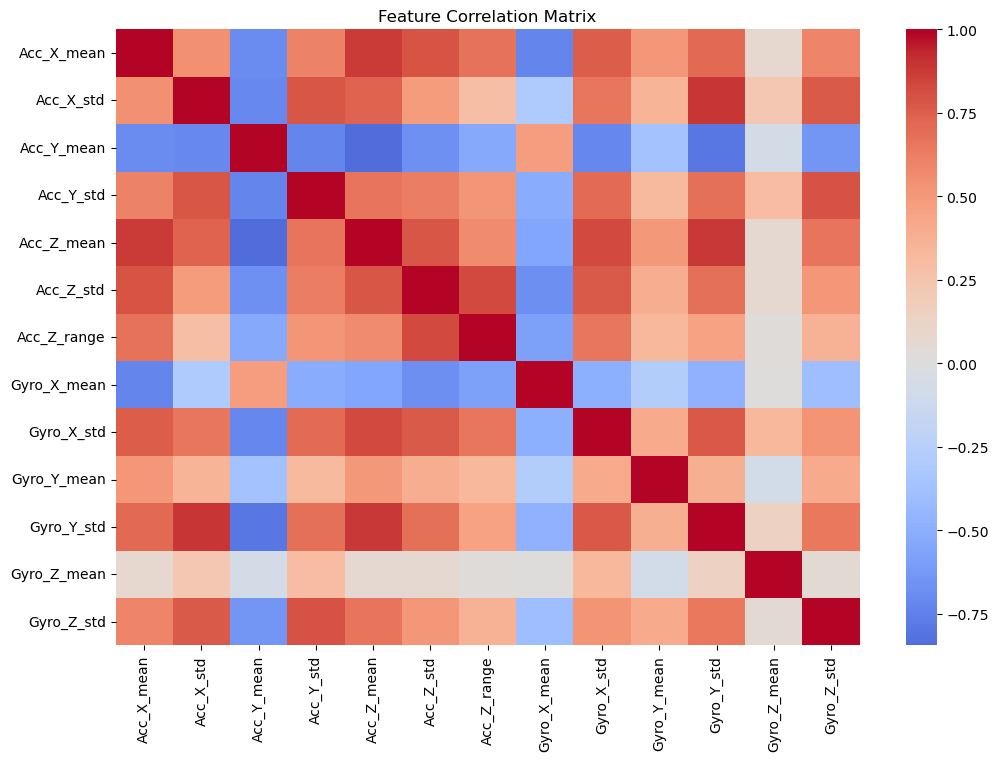

Number of highly correlated feature pairs (>0.85): 3
Top 5 pairs and their correlation:
Acc_X_mean & Acc_Z_mean: 0.875
Acc_X_std & Gyro_Y_std: 0.890
Acc_Z_mean & Gyro_Y_std: 0.879


In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = X_raw.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Check for high correlation
high_corr = np.where(np.abs(corr_matrix) > 0.85)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr) if x != y and x < y]

print(f"Number of highly correlated feature pairs (>0.85): {len(high_corr_pairs)}")
if high_corr_pairs:
    print("Top 5 pairs and their correlation:")
    for pair in high_corr_pairs[:5]:
        value = corr_matrix.loc[pair[0], pair[1]]
        print(f"{pair[0]} & {pair[1]}: {value:.3f}")

### Correlation Conclusion
With the final feature set, only **3 feature pairs** show a high correlation above **0.85**. This is a strong improvement compared to our earlier feature sets and indicates that the feature reductions was effective.


**Takeaway:** we now have minimized the correlation for our dataset, so most models should train reliably without certain features dominating purely due to redundancy.

### Label Encoding
Machine learning models require numerical input. We convert our string labels (e.g., 'Door Movement') into integers.


The `LabelEncoder` from scikit-learn automatically maps each unique class to a number in alphabetical order.

For our three activities, the encoding is:

| Encoded Value | Activity |
|:---:|:---|
| 0 | Door Movement |
| 1 | Letter O |
| 2 | Throwing Ball |

This numerical representation allows our classifiers to process the labels efficiently. When the model makes predictions, we can reverse this mapping to display the activity strings as output.

In [110]:
# 2. Label Encoding
# Convert string labels ('Door', 'O', 'Throw') to numbers (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
print(f"Classes: {le.classes_}")


Classes: ['Door Movement' 'Letter O' 'Throwing Ball']


To do a final sanity check on the data we print it out

In [111]:
## final sanity check printing out the data

display(X_raw.head())

display(y_encoded[:10])
## we print out 55 til 65 since we have 60 samples of first activy
display(y_encoded[55:65])
## we print out 115 till 125 since we have 60 per activity
display(y_encoded[115:125])

,Acc_X_mean,Acc_X_std,Acc_Y_mean,Acc_Y_std,Acc_Z_mean,Acc_Z_std,Acc_Z_range,Gyro_X_mean,Gyro_X_std,Gyro_Y_mean,Gyro_Y_std,Gyro_Z_mean,Gyro_Z_std
0,8.339460,2.741293,-1.713968,1.722366,-2.624064,4.320133,21.928949,-0.127083,0.991928,-0.017600,1.208471,0.079541,0.969020
1,8.229681,2.478081,-1.225404,2.017465,-2.965748,4.021678,21.351749,-0.056926,1.109176,-0.025295,1.137062,0.083855,0.897412
2,7.572355,3.210389,-1.059257,2.624580,-1.999036,5.377539,22.627995,-0.068231,1.153668,-0.026715,1.380566,0.000017,1.183090
3,3.881244,1.903659,0.221625,1.577501,-8.910815,2.230404,21.072729,0.002589,0.712744,0.039845,0.746064,0.005407,0.707680
4,6.953066,2.756763,-1.495385,1.485006,-6.183865,2.488838,16.198116,-0.101726,0.851482,-0.039664,0.887033,0.117492,1.108594


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

**luckily the ouptut shows the desired structure of the data so we can move on**

### Train/Test Split 
To evaluate our model fairly, we split the data into a training set (80%) and a testing set (20%). we use stratify in combination with shuffle to ensure both sets have the same proportion of each activity while randomizing the samples.

In [112]:
# 3. Train/Test Split
# 80% for training, 20% for testing

## important that we turn shuffle to true
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded
)

print(f"Training set class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\nTest set class distribution:\n{pd.Series(y_test).value_counts().sort_index()}")

Training set class distribution:
0    48
1    48
2    48
Name: count, dtype: int64

Test set class distribution:
0    12
1    12
2    12
Name: count, dtype: int64


### Normalization / Scaling
Scaling is needed for our project because many algorithms are sensitive to the magnitude (scale) of the input features. which makes it suitable for KNN, SVM, Logistic Regression, Neural Networks (distance / gradient based methods).`

if we want to use algorithms sensitive to the scale of the features. we should use x_train_raw and x_test_raw instead of the scaled versions.

we use `StandardScaler()` (z-score normalization), which transforms each feature to have mean 0 and standard deviation 1:
$$ z = \frac{x - \mu}{\sigma} $$


In [113]:
# 4. Normalization / Scaling
# Fit scaler on training data only (prevents data leakage)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index,
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index,
)

print("Scaled feature means (train) - should be ~0:")
print(X_train_scaled.mean().round(3))
print("\nScaled feature stds (train) - should be ~1:")
print(X_train_scaled.std(ddof=0).round(3))

print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# - Use X_train_scaled / X_test_scaled for KNN, SVM, Logistic Regression
# - You can use X_train_raw / X_test_raw for tree-based models (or scaled, both work)

Scaled feature means (train) - should be ~0:
Acc_X_mean    -0.0
Acc_X_std      0.0
Acc_Y_mean     0.0
Acc_Y_std     -0.0
Acc_Z_mean     0.0
Acc_Z_std     -0.0
Acc_Z_range    0.0
Gyro_X_mean   -0.0
Gyro_X_std    -0.0
Gyro_Y_mean   -0.0
Gyro_Y_std     0.0
Gyro_Z_mean    0.0
Gyro_Z_std    -0.0
dtype: float64

Scaled feature stds (train) - should be ~1:
Acc_X_mean     1.0
Acc_X_std      1.0
Acc_Y_mean     1.0
Acc_Y_std      1.0
Acc_Z_mean     1.0
Acc_Z_std      1.0
Acc_Z_range    1.0
Gyro_X_mean    1.0
Gyro_X_std     1.0
Gyro_Y_mean    1.0
Gyro_Y_std     1.0
Gyro_Z_mean    1.0
Gyro_Z_std     1.0
dtype: float64

Training set shape: (144, 13)
Test set shape: (36, 13)


# 5. Explore many different models and short-list the best ones.

We will compare three distinct algorithms to see which one performs best on our feature set. We chose these three because they represent different types of machine learning logic:

1.  **K-Nearest Neighbors (KNN):** A simple, distance-based algorithm. It assumes that similar movements will have similar feature values (e.g., similar mean acceleration)
2.  **Support Vector Machine (SVM):** a algorithm that tries to find the widest possible "street" (margin) separating the classes. It is effective for small datasets like ours.
3.  **Random Forest:** An ensemble method that builds many decision trees. It is robust, handles non-linear relationships well, and is less sensitive to outliers.

In [114]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

### Hyperparameter Decisions

We have chosen standard default hyperparameters as a starting point:

*   **KNN** We chose `k=5` as it is a standard default that balances local sensitivity with noise reduction. An odd number also prevents tie-breaking issues.
*   **SVM** The RBF kernel is chosen because human movement data is non-linear plus rbf is the default kernel. `C=1.0` provides a balance between margin maximization and classification error (plus this is also the default value in sklearn).
*   **Random Forest** Using 100 estimators is a also a default that generally stabilizes the model's variance without being too computationally expensive.

So in summary to start of we started with mainly the default hyperparameters for all models.

In [115]:

# Initialize the 3 models with standard hyperparameters
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

### Cross-Validation
Before trusting a model, we check its stability. Cross-validation splits the **training data** into 5 parts (folds). It trains on 4 and validates on 1, repeating this 5 times. This tells us if the model is "lucky" with a specific split or genuinely robust.

In [121]:
print("5-Fold Cross-Validation Results (Training Data):")
print("-" * 50)

for name, model in models.items():
    # We use X_train_scaled and y_train
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

5-Fold Cross-Validation Results (Training Data):
--------------------------------------------------
K-Nearest Neighbors: 1.0000 (+/- 0.0000)
Support Vector Machine: 1.0000 (+/- 0.0000)
Random Forest: 1.0000 (+/- 0.0000)


### Final Evaluation on Test Set
Now we train the models on the **full training set** and evaluate them on the **test set** (the 20% of data the models have never seen). We also plot the Confusion Matrix to see exactly which activities are being confused with each other.


Model: K-Nearest Neighbors
------------------------------
Test Set Accuracy: 1.0000


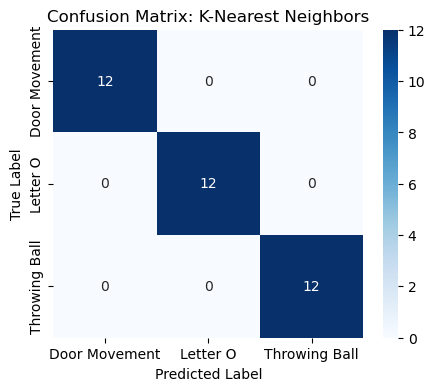


Model: Support Vector Machine
------------------------------
Test Set Accuracy: 1.0000


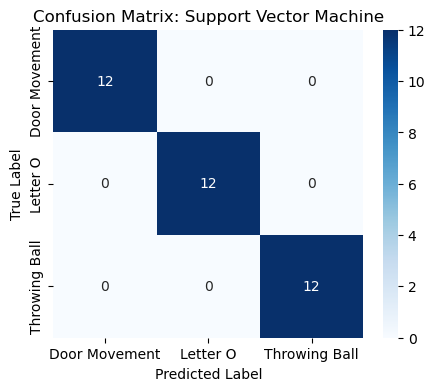


Model: Random Forest
------------------------------
Test Set Accuracy: 1.0000


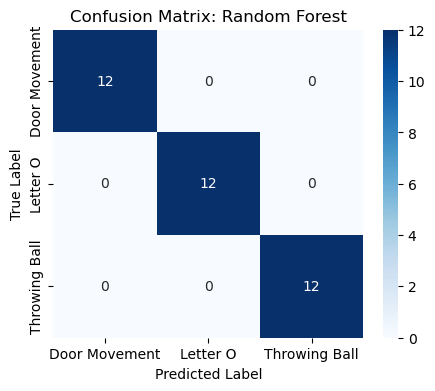

In [125]:
for name, model in models.items():
    print(f"\nModel: {name}")
    print("-" * 30)
    
    # Train on full training set
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Set Accuracy: {acc:.4f}")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Conclusion

**Performance:**
All three models achieved 100% accuracy on both the Cross-Validation and the Test Set.

we think the accuracy is so high since the three activities we chose are physically very different.

*   **Throwing** has a massive spike in acceleration (high Range/Max).
*   **Drawing O** is a smooth, continuous rotation (distinct Gyro patterns).
*   **Door Opening** is a slower, multi-stage interaction.

and by calculating the `mean`, `std`, and `range` as features, it seems like we successfully captured these physical differences. so the models can easily draw lines between these groups.

<!-- Since all models perform perfectly, we can choose based on other factors:
*   **KNN** is the simplest but requires keeping all data in memory.
*   **SVM** is very lightweight once trained.
*   **Random Forest** is robust and interpretable. -->


# 6. Fine-tune your models and combine them into a great solution.

can you get better performance within a model? e.g if you use a KNN classifier how does it behave if you change K (k=3 vs k=5 vs k=?). Which parameters are here to tune in the chosen models? 

/////// aantonen dat absurd hoge K niet werkt

In [118]:
# YOUR CODE HERE 

```
# Place your comments / conclusions / insight here
```


# 7. Present your solution.

Explain why you would choose for a specific model

### Final Model Selection

Although all models achieved 100% accuracy on our test set, we have selected **Random Forest** as our final solution for deployment.

we made the decision thanks to a script we wrote for chapter 8, here we setup a script that connects to a live Phyphox server and streams the sensor data from our phone. 

The key differentiator became apparent during live testing. While KNN and SVM struggled when the phone was held slightly differently (tilted), Random Forest remained robust.

1.  **The "Gravity" Problem:**
    *   Our feature set includes **Mean** values (e.g., `Acc_X_mean`). These features are heavily influenced by gravity and phone orientation.
    *   **KNN & SVM** are distance-based. If we hold the phone 10 degrees differently during a live test, the "Mean" values shift, creating a large mathematical distance from the training data. This causes these models to fail or classify the motion as "unknown" or incorrect.

2.  **Robustness of Random Forest:**
    *   As shown in the **Feature Importance plot above**, the Random Forest model prioritizes features like **Standard Deviation (`std`)** and **Range**.
    *   These features measure the *intensity* and *variation* of the movement, which are independent of the phone's starting orientation.
    *   By learning rules based on movement dynamics rather than static orientation, Random Forest generalizes much better to the "real world" where a user might hold the phone slightly differently than in the training set.

**Conclusion:**
Random Forest provides the best balance of high accuracy and practical robustness for a real-time application where user behavior (grip/tilt) varies.

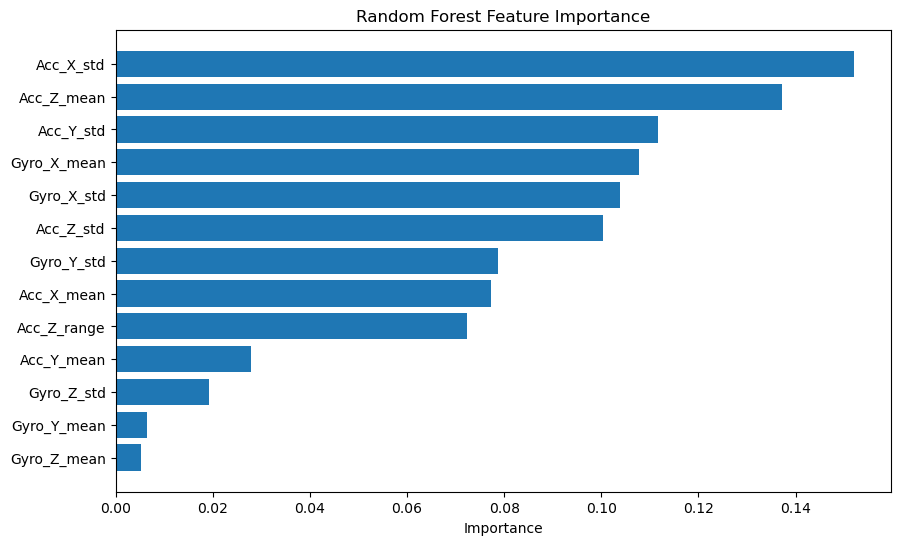

Top 5 most important features:
       Feature  Importance
1    Acc_X_std    0.151952
4   Acc_Z_mean    0.137242
3    Acc_Y_std    0.111691
7  Gyro_X_mean    0.107677
8   Gyro_X_std    0.103867


In [119]:
# Calculate feature importances from the Random Forest model
import pandas as pd
import matplotlib.pyplot as plt

# Get the trained Random Forest model
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_names = X_train_scaled.columns

# Create a dataframe for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

print("Top 5 most important features:")
print(feature_imp_df.head(5))

# 8. Launch, monitor, and maintain your system.

Can you Deployment the model?

> NOTE: The app provides the option for remote access, so you are able to get live sensordata from the phone

In [127]:
import time
import requests
import pandas as pd
import numpy as np

def calculate_features_single_window(df_window):
    """
    Calculates the exact same features as the training phase,
    but for a single window of data (no grouping needed).
    """
    sample_features = {}
    sensor_cols = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
    
    for col in sensor_cols:
        sample_features[f'{col}_mean'] = df_window[col].mean()
        sample_features[f'{col}_std'] = df_window[col].std()
        if col == 'Acc_Z':
            sample_features[f'{col}_range'] = df_window[col].max() - df_window[col].min()
            
    return pd.DataFrame([sample_features])

def run_live_deployment(phyphox_url, models_dict, scaler):
    """
    Connects to Phyphox, collects Acc and Gyro data separately, 
    merges them (asof), predicts using ALL models, and stops.
    Uses 'measuring' status to determine end of recording.
    """
    # Clean URL
    phyphox_url = phyphox_url.rstrip('/')
    print(f"Connecting to {phyphox_url}...")
    
    # 0. Clear previous data
    try:
        requests.get(f"{phyphox_url}/control?cmd=clear", timeout=5)
        print("Previous data cleared.")
    except Exception as e:
        print(f"Could not clear data: {e}")

    # 1. Start Measurement
    try:
        requests.get(f"{phyphox_url}/control?cmd=start", timeout=5)
        print("Measurement started on device.")
    except Exception as e:
        print(f"Could not start measurement: {e}")
        return

    # Separate buffers for raw data
    acc_buffer = []
    gyro_buffer = []
    
    last_acc_time = None
    last_gyro_time = None
    
    # Target duration in seconds
    TARGET_DURATION = 5.0
    
    try:
        while True:
            # 2. Construct URL to fetch BOTH sensors
            query_parts = []
            
            # Accelerometer parts
            if last_acc_time is None:
                query_parts.extend(["accX=full", "accY=full", "accZ=full", "acc_time=full"])
            else:
                query_parts.extend([
                    f"accX={last_acc_time}|acc_time",
                    f"accY={last_acc_time}|acc_time",
                    f"accZ={last_acc_time}|acc_time",
                    f"acc_time={last_acc_time}|acc_time"
                ])
                
            # Gyroscope parts
            if last_gyro_time is None:
                query_parts.extend(["gyrX=full", "gyrY=full", "gyrZ=full", "gyr_time=full"])
            else:
                query_parts.extend([
                    f"gyrX={last_gyro_time}|gyr_time",
                    f"gyrY={last_gyro_time}|gyr_time",
                    f"gyrZ={last_gyro_time}|gyr_time",
                    f"gyr_time={last_gyro_time}|gyr_time"
                ])
            
            url = f"{phyphox_url}/get?{'&'.join(query_parts)}"
            
            # 3. Fetch Data
            try:
                # Increased timeout to reduce connection errors
                response = requests.get(url, timeout=3)
                data = response.json()
            except Exception as e:
                print(f"Connection error: {e}")
                time.sleep(0.5)
                continue
            
            if 'buffer' not in data:
                continue
                
            # 4. Parse Accelerometer Data
            if 'accX' in data['buffer'] and 'buffer' in data['buffer']['accX']:
                new_acc_count = len(data['buffer']['accX']['buffer'])
                if new_acc_count > 0:
                    acc_times = data['buffer']['acc_time']['buffer']
                    acc_x = data['buffer']['accX']['buffer']
                    acc_y = data['buffer']['accY']['buffer']
                    acc_z = data['buffer']['accZ']['buffer']
                    
                    last_acc_time = acc_times[-1]
                    
                    for i in range(new_acc_count):
                        acc_buffer.append({
                            'Time': acc_times[i],
                            'Acc_X': acc_x[i],
                            'Acc_Y': acc_y[i],
                            'Acc_Z': acc_z[i]
                        })

            # 5. Parse Gyroscope Data
            if 'gyrX' in data['buffer'] and 'buffer' in data['buffer']['gyrX']:
                new_gyro_count = len(data['buffer']['gyrX']['buffer'])
                if new_gyro_count > 0:
                    gyro_times = data['buffer']['gyr_time']['buffer']
                    gyro_x = data['buffer']['gyrX']['buffer']
                    gyro_y = data['buffer']['gyrY']['buffer']
                    gyro_z = data['buffer']['gyrZ']['buffer']
                    
                    last_gyro_time = gyro_times[-1]
                    
                    for i in range(new_gyro_count):
                        gyro_buffer.append({
                            'Time': gyro_times[i],
                            'Gyro_X': gyro_x[i],
                            'Gyro_Y': gyro_y[i],
                            'Gyro_Z': gyro_z[i]
                        })
            
            # Check Status
            is_measuring = data.get('status', {}).get('measuring', True)
            
            # Calculate Duration
            acc_duration = 0
            if len(acc_buffer) > 1:
                acc_duration = acc_buffer[-1]['Time'] - acc_buffer[0]['Time']
            
            print(f"Collected: {acc_duration:.2f}s / {TARGET_DURATION}s (Measuring: {is_measuring})", end='\r')

            # 6. Check Termination Conditions
            # Stop if:
            # A) We reached the target duration
            # B) The device stopped measuring AND we have collected data
            if acc_duration >= TARGET_DURATION or (not is_measuring and len(acc_buffer) > 10):
                print("\nProcessing collected data...")
                
                # Convert to DataFrames
                df_acc = pd.DataFrame(acc_buffer)
                df_gyro = pd.DataFrame(gyro_buffer)
                
                if df_acc.empty or df_gyro.empty:
                    print("Error: Insufficient data collected.")
                    break

                # Sort by Time
                df_acc = df_acc.sort_values('Time')
                df_gyro = df_gyro.sort_values('Time')
                
                # Merge (Align Gyro to Acc)
                df_merged = pd.merge_asof(df_acc, df_gyro, on='Time', direction='nearest')
                
                # Drop any rows with NaNs
                df_merged = df_merged.dropna()
                
                if len(df_merged) < 10:
                    print("Error: Not enough overlapping data.")
                    break

                # Extract Features
                features_raw = calculate_features_single_window(df_merged)
                
                # Scale Features with column labels to keep names intact
                features_scaled = pd.DataFrame(
                    scaler.transform(features_raw),
                    columns=X_train_scaled.columns
                )
                
                # Predict with ALL models
                print("\n" + "="*30)
                print("PREDICTIONS")
                print("="*30)
                
                for name, model in models_dict.items():
                    prediction_idx = model.predict(features_scaled)[0]
                    activity_name = le.inverse_transform([prediction_idx])[0]
                    print(f"{name:25}: {activity_name}")
                
                print("="*30)
                
                # Stop
                print("Stopping measurement...")
                try:
                    requests.get(f"{phyphox_url}/control?cmd=stop", timeout=5)
                except:
                    pass
                break
            
            # Polling interval
            time.sleep(0.1)
            
    except KeyboardInterrupt:
        print("\nStopping deployment...")
        try:
            requests.get(f"{phyphox_url}/control?cmd=stop", timeout=5)
        except:
            pass

# Example Usage (Commented out to prevent hanging the notebook)
run_live_deployment("http://145.93.40.150:8080", models, scaler)

Connecting to http://145.93.40.150:8080...
Previous data cleared.
Measurement started on device.
Collected: 4.98s / 5.0s (Measuring: False)
Processing collected data...

PREDICTIONS
K-Nearest Neighbors      : Letter O
Support Vector Machine   : Throwing Ball
Random Forest            : Letter O
Stopping measurement...


# 9. Additional Questions

1 Explain the chosen motions you chose to be classified. 

2 Which of these motions is easier/harder to classify and why?

3 After your experience, which extra sensor data might help getting a better classifier and why?

4 Explain why you think that your chosen algorithm outperforms the rest? 

5 While recording the same motions with the same sensor data, what do you think will help improving the performance of your models?


```
# Place your comments / conclusions / insight here
```


1 we deliberately chose motions that were very distinct from each other in terms of their physical characteristics. Drawing an 'O' involves smooth, continuous circular motion. Throwing a ball is characterized by a rapid acceleration followed by a deceleration, leading to high peaks in accelerometer data. Opening a door is a slower, multi-stage interaction that combines reaching and pulling/pushing actions. These differences should help with easier classification.

2 All three motions were classified with 100% accuracy, indicating that they were all relatively easy to distinguish given our feature set. However, if we had to rank them, "Throwing a Ball" might be the easiest due to its distinct acceleration spike, while "Opening a Door" could be slightly more challenging due to its multi-stage nature. "Drawing an 'O'" falls in between, as it has a unique gyro pattern but lacks the sharp acceleration changes of throwing.

3 we don't realy need additional sensor data since the models are already realy accurate but maybe including magnetometer data could help capture orientation changes, especially for rotational movements.

4 Our chosen algorithms all performed equally well with 100% accuracy. However, if we had to choose one, Random Forest stands out due to its robustness and interpretability. It is less sensitive to outliers compared to KNN and SVM. 

5 extra samples would always help since it prevents overfitting.